In [1]:
import specdist as pi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.collections import LineCollection
from matplotlib.ticker import LogLocator
import re
scientific_notation = pi.scientific_notation
from scipy.linalg import cholesky, LinAlgError
from scipy.linalg import block_diag

import warnings; warnings.simplefilter('ignore')

path_to_figures = "/Users/boris/Work/SPECTRAL-DISTORTIONS/figures/"

xinj_to_mass = 4.698e-4 #m in ev = 4.698e-4 xinj
#1./4.698e-4*2. = 4257.130693912303

# sd_lib_bare = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('bare',sd_lib_bare)


# sd_lib_lyc = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc',sd_lib_lyc)

# sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)




label_y_firas = r'$y_\mathrm{COBE}=1.5\times 10^{-5}$'
label_mu_firas = r'$\mu_\mathrm{COBE}=9\times 10^{-5}$'
label_fdm = 'Effective Dark Matter Fraction, '+r'$\epsilon f_\mathrm{dm}$'
label_mdm = 'Particle Mass, ' +r'$m_\mathrm{dm}\,\,[\mathrm{eV}]$'
label_xe = 'Free Electron Fraction, '+r'$X_\mathrm{e}$'
label_Zeta_e = 'Ionization History, '+r'$\zeta(z) = \Delta X_\mathrm{e}/X_\mathrm{e}$'
label_redshift = 'Redshift, '+r'$z$'
label_mu_dist =  'Chemical Potential, '+r'$\mu$'
label_injection_frequency = "Scaled Injection Frequency, "+ r'$x_{\mathrm{inj,0}}$'
label_scaled_frequency = "Scaled Frequency, "+ r'$x=h\nu/k_{_\mathrm{B}}T_{_\mathrm{CMB}}$'
label_frequency_in_GHz = "Frequency,  "+ r'$\nu \quad [\mathrm{GHz}]$'
label_intensity = "Intensity, "+r'$\Delta I_x \quad [\mathrm{Jy/sr}]$'
label_intensity_kJy = "Intensity, "+r'$\Delta I_x \quad [\mathrm{kJy/sr}]$'
label_injection_energy = "Injection Energy, "+ r'$E_{\mathrm{inj,0}}$' + " [eV]"
xinj_to_Einj = 4.698e-4/2.
label_Gamma = "Decay Rate, "+r"$\Gamma_X\quad[\mathrm{s^{-1}}]$"

label_zX = "Maximum Injection Redshift, "+ r'$z_X$'
sd = pi

In [2]:
sd_lib_xe_history = pi.specdist_ct_spectra_lib()
pi.load_ct_spectra_lib('xe_history_200720',sd_lib_xe_history)
# sd_lib_xe_history_finj_fisher = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('xe_history_200720_finj_fisher',sd_lib_xe_history_finj_fisher)
# sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)

In [4]:
sd_lib_xe_history.Xe_PCA_EigenModes['E1']['z']

array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 3.9998e+03, 3.9999e+03,
       4.0000e+03])

In [3]:
gamma_asked = 1e-17
xinj_asked = 1e-5
x_asked = np.logspace(-10,10,300)
S_xe_history = pi.GetSpectra(gamma_asked,xinj_asked,x_asked,sd_lib_xe_history)


[]

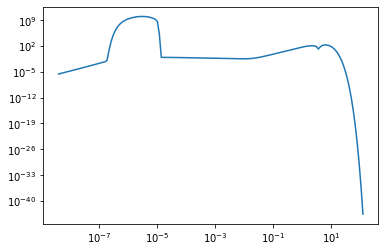

In [4]:
plt.plot(S_xe_history['x'],np.abs(S_xe_history['DI']))
plt.loglog()

In [50]:
find_nearests =  pi.find_nearests

def GetXeHistory(Gamma_inj_asked,x_inj_asked,z_asked,specdist_ct_spectra_lib,omega_cdm=0.12,fdm_asked=1e0,get_pca_constraint='yes'):
    x_asked = z_asked
    r1 = (Gamma_inj_asked - specdist_ct_spectra_lib.Gamma_inj_min)
    r2 = (specdist_ct_spectra_lib.Gamma_inj_max - Gamma_inj_asked)
    r3 = (x_inj_asked - specdist_ct_spectra_lib.x_inj_min)
    r4 = (specdist_ct_spectra_lib.x_inj_max - x_inj_asked)
    #print(r1,r2,r3,r4)

    if (r1 < 0) or (r2 < 0) or (r3 < 0) or (r4 < 0):
        #print('filling with nans')
        array_x_asked =  np.empty(len(x_asked))
        array_x_asked[:] = np.nan
        array_S_result = np.empty(len(x_asked))
        array_S_result[:] =  np.nan
        F_gamma_asked_xinj_asked = np.nan

    else:
        X_2d =  specdist_ct_spectra_lib.X_2d
        DI_2d = specdist_ct_spectra_lib.DI_2d
        finj_2d = specdist_ct_spectra_lib.finj_2d
        
        DXe_Xe_2d = specdist_ct_spectra_lib.DXe_Xe_2d
        Xe_redshifts_2d = specdist_ct_spectra_lib.Xe_redshifts_2d

        Gamma_values = specdist_ct_spectra_lib.Gamma_values
        x_inj_values =  specdist_ct_spectra_lib.x_inj_values
        # print(Gamma_values)
        # print(x_inj_values)
        # print(find_nearests(Gamma_values, Gamma_inj_asked))
        id_gamma_low = find_nearests(Gamma_values, Gamma_inj_asked)[0]
        id_gamma_high = find_nearests(Gamma_values, Gamma_inj_asked)[1]

        id_xinj_low = find_nearests(x_inj_values, x_inj_asked)[0]
        id_xinj_high = find_nearests(x_inj_values, x_inj_asked)[1]

        #print(id_gamma_low,id_gamma_high,id_xinj_low,id_xinj_high)

        #DI_2d[id_gamma_low][id_xinj_low]  #DI_2d[id_gamma_low][id_xinj_high]
        #X_2d[id_gamma_low][id_xinj_low]   #X_2d[id_gamma_low][id_xinj_high]

        #DI_2d[id_gamma_high][id_xinj_low]  #DI_2d[id_gamma_high][id_xinj_high]
        #X_2d[id_gamma_high][id_xinj_low]   #X_2d[id_gamma_high][id_xinj_high]
        #S = [[X_2d[id_gamma_low][id_xinj_low],DI_2d[id_gamma_low][id_xinj_low]],[X_2d[id_gamma_low][id_xinj_high],DI_2d[id_gamma_low][id_xinj_high]],[X_2d[id_gamma_high][id_xinj_low],DI_2d[id_gamma_high][id_xinj_low]],[X_2d[id_gamma_high][id_xinj_high],DI_2d[id_gamma_high][id_xinj_high]]]
        F = [finj_2d[id_gamma_low][id_xinj_low],finj_2d[id_gamma_low][id_xinj_high],finj_2d[id_gamma_high][id_xinj_low],finj_2d[id_gamma_high][id_xinj_high]]
        DXe_Xe = [[Xe_redshifts_2d[id_gamma_low][id_xinj_low],DXe_Xe_2d[id_gamma_low][id_xinj_low]],
                  [Xe_redshifts_2d[id_gamma_low][id_xinj_high],DXe_Xe_2d[id_gamma_low][id_xinj_high]],
                  [Xe_redshifts_2d[id_gamma_high][id_xinj_low],DXe_Xe_2d[id_gamma_high][id_xinj_low]],
                  [Xe_redshifts_2d[id_gamma_high][id_xinj_high],DXe_Xe_2d[id_gamma_high][id_xinj_high]]]


        dict = {
        "gamma_low": Gamma_values[id_gamma_low],
        "gamma_high": Gamma_values[id_gamma_high],
        "xinj_low": x_inj_values[id_xinj_low],
        "xinj_high": x_inj_values[id_xinj_high],
        "DXe_Xe": DXe_Xe,
        "finj": F
        }

        #print(F)

        gamma_low = dict["gamma_low"]
        gamma_high = dict["gamma_high"]
        xinj_low = dict["xinj_low"]
        xinj_high = dict["xinj_high"]
        S = dict["DXe_Xe"]
        F = dict["finj"]

        #print(gamma_low)
        #print(gamma_high)

        S_gamma_low_xinj_low = S[0]
        S_gamma_low_xinj_high = S[1]
        S_gamma_high_xinj_low = S[2]
        S_gamma_high_xinj_high = S[3]

        F_gamma_low_xinj_low = F[0][0]
        F_gamma_low_xinj_high = F[1][0]
        F_gamma_high_xinj_low = F[2][0]
        F_gamma_high_xinj_high = F[3][0]

        Gamma_asked = Gamma_inj_asked
        xinj_asked = x_inj_asked

        #check if nan in any of the arrays:
        Arrays_list = [S_gamma_low_xinj_low,
                      S_gamma_low_xinj_high,
                      S_gamma_high_xinj_low,
                      S_gamma_high_xinj_high]
        has_nan = False
        for p in Arrays_list:
            array = p
            array_sum = np.sum(array)
            has_nan += np.isnan(array_sum)
        if np.sum(has_nan):
            #print('filling with nans')
            array_x_asked =  np.empty(len(x_asked))
            array_x_asked[:] = np.nan
            array_S_result = np.empty(len(x_asked))
            array_S_result[:] =  np.nan
            F_gamma_asked_xinj_asked = np.nan
        else:
            nx = int(1e4)


            ############### xinj_low
            new_x_min = np.maximum(np.min(S_gamma_low_xinj_low[0]),np.min(S_gamma_high_xinj_low[0]))
            new_x_max = np.minimum(np.max(S_gamma_low_xinj_low[0]),np.max(S_gamma_high_xinj_low[0]))
            new_x_array = np.logspace(np.log10(new_x_min),np.log10(new_x_max),nx)
            new_x_array = new_x_array[1:-1]


            f_gamma_low = interp1d(S_gamma_low_xinj_low[0], S_gamma_low_xinj_low[1])
            f_gamma_high = interp1d(S_gamma_high_xinj_low[0], S_gamma_high_xinj_low[1])

            new_S_gamma_low = f_gamma_low(new_x_array)
            new_S_gamma_high = f_gamma_high(new_x_array)

            if gamma_low == Gamma_asked:
                w = 1.
            elif gamma_high == Gamma_asked:
                w = 0.
            else:
                #w = (gamma_high - Gamma_asked)/(gamma_high - gamma_low)
                w = (np.log(gamma_high) - np.log(Gamma_asked))/(np.log(gamma_high) - np.log(gamma_low))
            new_S_gamma_asked = w*new_S_gamma_low + (1.-w)*new_S_gamma_high
#             print('xinj _low : w_gamma = %.14e'%w)



            S_gamma_asked_xinj_low = [[],[]]
            S_gamma_asked_xinj_low[0] = new_x_array
            S_gamma_asked_xinj_low[1] = new_S_gamma_asked

            F_gamma_asked_xinj_low = w*F_gamma_low_xinj_low + (1.-w)*F_gamma_high_xinj_low

            ############# xinj_high

            new_x_min = np.maximum(np.min(S_gamma_low_xinj_high[0]),np.min(S_gamma_high_xinj_high[0]))
            new_x_max = np.minimum(np.max(S_gamma_low_xinj_high[0]),np.max(S_gamma_high_xinj_high[0]))
            new_x_array = np.logspace(np.log10(new_x_min),np.log10(new_x_max),nx)
            new_x_array = new_x_array[1:-1]

            f_gamma_low = interp1d(S_gamma_low_xinj_high[0], S_gamma_low_xinj_high[1])
            f_gamma_high = interp1d(S_gamma_high_xinj_high[0], S_gamma_high_xinj_high[1])

            new_S_gamma_low = f_gamma_low(new_x_array)
            new_S_gamma_high = f_gamma_high(new_x_array)

            if gamma_low == Gamma_asked:
                w = 1.
            elif gamma_high == Gamma_asked:
                w = 0.
            else:
                #w = (gamma_high - Gamma_asked)/(gamma_high - gamma_low)
                w = (np.log(gamma_high) - np.log(Gamma_asked))/(np.log(gamma_high) - np.log(gamma_low))
#             #w = (gamma_high - Gamma_asked)/(gamma_high - gamma_low)
#             w = (np.log(gamma_high) - np.log(Gamma_asked))/(np.log(gamma_high) - np.log(gamma_low))
            new_S_gamma_asked = w*new_S_gamma_low + (1.-w)*new_S_gamma_high
#             print('xinj _high : w_gamma = %.14e'%w)

            S_gamma_asked_xinj_high = [[],[]]
            S_gamma_asked_xinj_high[0] = new_x_array
            S_gamma_asked_xinj_high[1] = new_S_gamma_asked

            F_gamma_asked_xinj_high = w*F_gamma_low_xinj_low + (1.-w)*F_gamma_high_xinj_high

            ############# interpolation between xinjs
            new_x_min = np.maximum(np.min(S_gamma_asked_xinj_low[0]),np.min(S_gamma_asked_xinj_high[0]))
            new_x_max = np.minimum(np.max(S_gamma_asked_xinj_low[0]),np.max(S_gamma_asked_xinj_high[0]))
            new_x_array = np.logspace(np.log10(new_x_min),np.log10(new_x_max),nx)
            new_x_array = new_x_array[1:-1]

            f_xinj_low = interp1d(S_gamma_asked_xinj_low[0], S_gamma_asked_xinj_low[1])
            f_xinj_high = interp1d(S_gamma_asked_xinj_high[0], S_gamma_asked_xinj_high[1])

            new_S_xinj_low = f_xinj_low(new_x_array)
            new_S_xinj_high = f_xinj_high(new_x_array)

            #w = (xinj_high - xinj_asked)/(xinj_high - xinj_low)
            w = (np.log(xinj_high) - np.log(xinj_asked))/(np.log(xinj_high) - np.log(xinj_low))
#             print('xinj_high = %.14e'%xinj_high)
#             print('w_xinj = %.14e'%w)

            new_S_xinj_asked = w*new_S_xinj_low + (1.-w)*new_S_xinj_high

            S_gamma_asked_xinj_asked = [[],[]]
            S_gamma_asked_xinj_asked[0] = new_x_array
            S_gamma_asked_xinj_asked[1] = new_S_xinj_asked

            F_gamma_asked_xinj_asked = w*F_gamma_asked_xinj_low + (1.-w)*F_gamma_asked_xinj_high


            f_gamma_asked_xinj_asked = interp1d(S_gamma_asked_xinj_asked[0], S_gamma_asked_xinj_asked[1])
            ########### get spectra at required x values
            bound_x_min = np.min(S_gamma_asked_xinj_asked[0])
            bound_x_max = np.max(S_gamma_asked_xinj_asked[0])

            array_x_asked = np.asarray(x_asked)

            min_x_asked = np.min(array_x_asked)
            max_x_asked = np.max(array_x_asked)

            id_min = 0
            id_max = None
            if min_x_asked < bound_x_min:
                id_min = find_nearests(array_x_asked, bound_x_min)[1]
            if max_x_asked > bound_x_max:
                id_max = find_nearests(array_x_asked, bound_x_max)[0]
            array_x_asked = array_x_asked[id_min:id_max]

            array_S_result = f_gamma_asked_xinj_asked(array_x_asked)
    #print(F_gamma_asked_xinj_asked)
    fdm = 1./1.3098e4*F_gamma_asked_xinj_asked*x_inj_asked*(omega_cdm/0.12)**-1
    array_DXe_Xe = array_S_result*fdm_asked/fdm
    
    #print(fdm)
    if get_pca_constraint == 'yes':
        z1 = specdist_ct_spectra_lib.Xe_PCA_EigenModes['E1']['z']
        E1 = specdist_ct_spectra_lib.Xe_PCA_EigenModes['E1']['values']
        z2 = specdist_ct_spectra_lib.Xe_PCA_EigenModes['E2']['z']
        E2 = specdist_ct_spectra_lib.Xe_PCA_EigenModes['E2']['values']
        z3 = specdist_ct_spectra_lib.Xe_PCA_EigenModes['E3']['z']
        E3 = specdist_ct_spectra_lib.Xe_PCA_EigenModes['E3']['values']
        
        f_E1 = interp1d(z1, E1)
        f_E2 = interp1d(z2, E2)
        f_E3 = interp1d(z3, E3)
        #print(z)
        
        f = interp1d(array_x_asked, array_S_result)
        
        min_z1 = max(np.min(z1),np.min(array_x_asked))
        max_z1 = min(np.max(z1),np.max(array_x_asked))
        
        min_z2 = max(np.min(z2),np.min(array_x_asked))
        max_z2 = min(np.max(z2),np.max(array_x_asked))
        
        min_z3 = max(np.min(z3),np.min(array_x_asked))
        max_z3 = min(np.max(z3),np.max(array_x_asked))
        
        new_z1 = np.linspace(min_z1,max_z1,5000)
        new_z2 = np.linspace(min_z2,max_z2,5000)
        new_z3 = np.linspace(min_z3,max_z3,5000)

        
        zeta1 = f(new_z1)
        zeta2 = f(new_z2)
        zeta3 = f(new_z3)
        
        integrand_rho1 = zeta1*f_E1(new_z1)
        integrand_rho2 = zeta2*f_E2(new_z2)
        integrand_rho3 = zeta3*f_E3(new_z3)
        
        rho1 = np.trapz(integrand_rho1, x=new_z1)/fdm
        rho2 = np.trapz(integrand_rho2, x=new_z2)/fdm
        rho3 = np.trapz(integrand_rho3, x=new_z3)/fdm
        
        sigma1 = 0.12
        sigma2 = 0.19
        sigma3 = 0.35
        
        fdm_pca_lim = 2.*np.sqrt(rho1**2/sigma1**2+rho2**2/sigma2**2+rho3**2/sigma3**2)
    else:
        fdm_pca_lim = 0.

    r_dict = {
              "z":array_x_asked,
              "DXe_Xe": array_DXe_Xe,
              "fdm_pca_lim": fdm_pca_lim
              }

    return r_dict

In [4]:
f_dm_asked = 1.e-10
gamma_asked = 1e-17
xinj_asked = 1e9
z_asked = np.logspace(-3,6,300)
S_xe_history = pi.GetXeHistory(gamma_asked,xinj_asked,z_asked,sd_lib_xe_history)
print(S_xe_history["fdm_pca_lim"])

nan


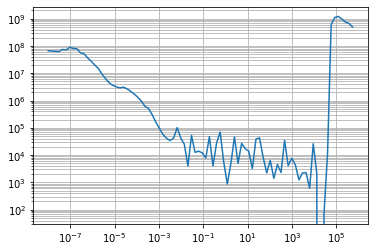

In [6]:
xinj = np.logspace(-8,8,100)
fdm_pca = []
for x in xinj:
    S_xe_history = pi.GetXeHistory(gamma_asked,x,z_asked,sd_lib_xe_history)
    fdm_pca.append(S_xe_history['fdm_pca_lim'])
fdm_pca = np.asarray(fdm_pca)

plt.plot(xinj,fdm_pca)
plt.loglog()
# plt.ylim(1e-5,1e1)
plt.grid(which='both')

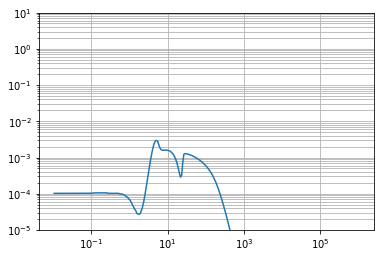

In [21]:
plt.plot(S_xe_history['z'],np.abs(S_xe_history['DXe_Xe']))
plt.loglog()
plt.ylim(1e-5,1e1)
plt.grid(which='both')

(0.01, 10000.0)

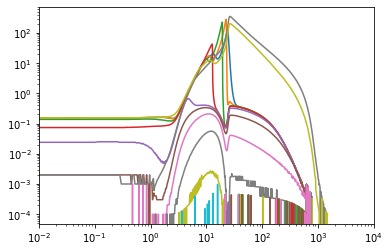

In [30]:
for i in range(len(sd_lib_xe_history.Xe_values_2d[0])):
    if i%10 == 0:
        Xe = sd_lib_xe_history.DXe_Xe_2d[0][i]
        z = sd_lib_xe_history.Xe_redshifts_2d[0][i]
        plt.plot(z,Xe)
plt.loglog()
plt.xlim(0.01,1e4)

(0.01, 10000.0)

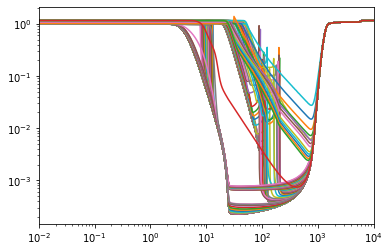

In [49]:
for i in range(len(sd_lib_xe_history_finj_fisher.Xe_values_2d[0])):
    Xe = sd_lib_xe_history_finj_fisher.Xe_values_2d[0][i]
    z = sd_lib_xe_history_finj_fisher.Xe_redshifts_2d[0][i]
    plt.plot(z,Xe)
plt.loglog()
plt.xlim(0.01,1e4)

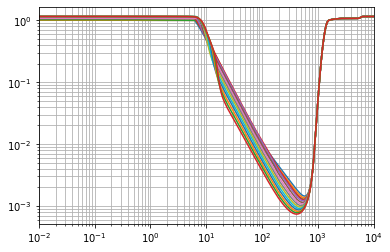

In [94]:
for i in range(len(sd_lib_xe_history.Xe_values_2d[0])):
    Xe = sd_lib_xe_history.Xe_values_2d[0][i]
    z = sd_lib_xe_history.Xe_redshifts_2d[0][i]
    xinj = sd_lib_xe_history.x_inj_values[i]
    if i>=170:
        plt.plot(z,Xe,label='xinj=%.3e'%xinj)
plt.loglog()
plt.xlim(0.01,1e4)
#plt.legend(loc=3)
plt.grid(which='both')
plt.savefig(path_to_figures + '/figures_for_paper_Xe.pdf')

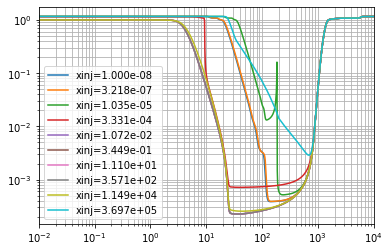

In [56]:
for i in range(len(sd_lib_xe_history_finj_fisher.Xe_values_2d[0])):
    Xe = sd_lib_xe_history_finj_fisher.Xe_values_2d[0][i]
    z = sd_lib_xe_history_finj_fisher.Xe_redshifts_2d[0][i]
    xinj = sd_lib_xe_history_finj_fisher.x_inj_values[i]
    if i%20 == 0:
        plt.plot(z,Xe,label='xinj=%.3e'%xinj)
plt.loglog()
plt.xlim(0.01,1e4)
plt.legend(loc=3)
plt.grid(which='both')
plt.savefig(path_to_figures + '/figures_for_paper_Xe_finj_fisher.pdf')

In [57]:
1./1.31e4*307845.44640415715*1e-08

2.3499652397263905e-07

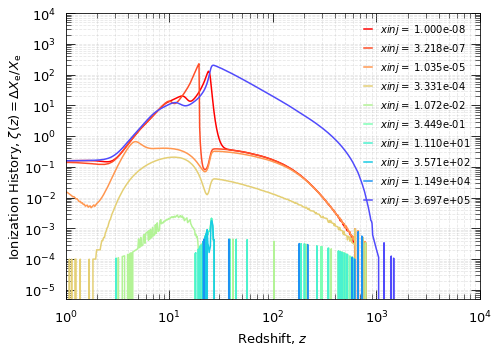

In [51]:
Xe = []
z = []

DXe_Xe = []
DXe_Xe_fisher = []

Xe_noinj = []
z_noinj = []

xinj = []
# fname = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/ct_spectra/case_reio_paper_2020/outputs/Xe_Recfast++.DM_decay_heating.Rec_corrs_CT2010.Tr0.dat'
# for i in np.arange(6).tolist():
#     D = np.loadtxt(fname)
#     Xe.append(D[:,1])
#     z.append(D[:,0])
#     fname = fname.replace(str(i)+'.dat',str(i+1)+'.dat')
#     #print(fname)
# # np.loadtxt
# fname = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/ct_spectra/case_reio_paper_2020/outputs/Xe_Recfast++.Rec_corrs_CT2010.Tr.reion_VP.dat'
# D = np.loadtxt(fname)
# Xe.append(D[:,1])
# z.append(D[:,0])

for i in range(len(sd_lib_xe_history.Xe_values_2d[0])):
    #if i%5 == 0:
    Xe.append(sd_lib_xe_history.Xe_values_2d[0][i])
    z.append(sd_lib_xe_history.Xe_redshifts_2d[0][i])
    Xe_noinj.append(sd_lib_xe_history.Xe_values_no_inj_2d[0][i])
    z_noinj.append(sd_lib_xe_history.Xe_redshifts_no_inj_2d[0][i])
    DXe_Xe.append(sd_lib_xe_history.DXe_Xe_2d[0][i])
    DXe_Xe_fisher.append(sd_lib_xe_history_finj_fisher.DXe_Xe_2d[0][i])
    xinj.append(sd_lib_xe_history_finj_fisher.x_inj_values[i])




#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 13
title_size = 13
legend_size = 25
handle_length = 0.8



ymin=5e-6
ymax = 1e4
x_max = 1e4
x_min = 1
ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel(label_redshift,size=title_size)
ax.set_ylabel(label_Zeta_e,size=title_size)
ax.yaxis.set_label_coords(-.1,0.5)


ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(True) #(3)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=5)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=5)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)

# manipulate x-axis ticks and labels
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(True) #(3)

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
i = 0
# gvals = [1e-15,1e-14,2e-14,5e-14,1e-13,2e-13,5e-13]
color=iter(cm.rainbow(np.linspace(1.,0,len(z))))
for i in range((len(z))):
    col = next(color)
    if i%20==0:
        
        ax.plot(z[i],np.abs(DXe_Xe[i]),c=col,ls='-',label=r'$xinj=$ %.3e'%xinj[i])
        #ax.plot(z[i],np.abs(DXe_Xe_fisher[i]),c=col,ls='--',label=r'$xinj=$ %.3e'%xinj[i])




# ax.text(0.75, 0.1, r'$f_\mathrm{dm}=10^{-5}$', transform=ax.transAxes, fontsize=9, verticalalignment='top',
#           bbox=dict(boxstyle='round', facecolor='grey', alpha=0.2))


# ax.text(0.03, 0.11, r'$\Gamma_\mathrm{inj}=$'+scientific_notation(ct.ct_Gamma_dec)+r'$\,\mathrm{s}^{-1}$', transform=ax.transAxes, fontsize=10, verticalalignment='top',
#           bbox=dict(boxstyle='round', facecolor='r', alpha=0.2))


# plt.ylim(-2.,5)
#plt.xlim(1e-3,13)

ax.legend(loc=1,ncol=1,frameon=False,framealpha=0.6,fontsize = 10,handlelength=handle_length)

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_DXe_Xe.pdf')
plt.show()
plt.close(fig)

In [3]:
Nx = 400
xi_array = np.logspace(-8,8,Nx)

#Gamma_values = [1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15,1e-16,1e-17]
Gamma_values = [1e-17]
#gamma_labels = [r'$10^{-8}$',r'$10^{-9}$',r'$10^{-10}$',r'$10^{-11}$',r'$10^{-12}$',r'$10^{-13}$',r'$10^{-14}$',r'$10^{-15}$',r'$10^{-16}$',r'$10^{-17}$']
gamma_labels = [r'$10^{-17}$']





firas = sd.firas()
edges = sd.edges()
a_dict = {}
a_dict['firas'] = firas
a_dict['edges'] = edges
a_dict['add_edges'] = 'yes'

# Gamma_values = np.logspace(-17,-8,3)
# for gammas in Gamma_values:
#     xi_array = np.logspace(-16,-10,100)
#     D = sd.pi_run_fisher_constraints([gammas],xi_array,sd_lib_bare,**a_dict)
#     #print(D['curves'][0]['fdm'])

f_dm_fisher_xe_history = sd.pi_run_fisher_constraints(Gamma_values,xi_array,sd_lib_xe_history,**a_dict)
f_dm_fisher_xe_history_finj_fisher = sd.pi_run_fisher_constraints(Gamma_values,xi_array,sd_lib_xe_history_finj_fisher,**a_dict)
# f_dm_fisher_lyc_reio = sd.pi_run_fisher_constraints(Gamma_values,xi_array,sd_lib_lyc_reio,**a_dict)




In [4]:
sd.pi_run_fisher_constraints([1e-17],[1e-8],sd_lib_xe_history,**a_dict)

{'curves': [{'x': [1e-08],
   'fdm': array([2.35032407e-07]),
   'finj': array([307845.44640416])}],
 'Gamma_inj': [1e-17]}

In [6]:
pi.pi_run_fisher_constraints([1e-17],[1e-8],sd_lib_xe_history_finj_fisher,**a_dict)

{'curves': [{'x': [1e-08],
   'fdm': array([2.35818329e-07]),
   'finj': array([308874.84675715])}],
 'Gamma_inj': [1e-17]}

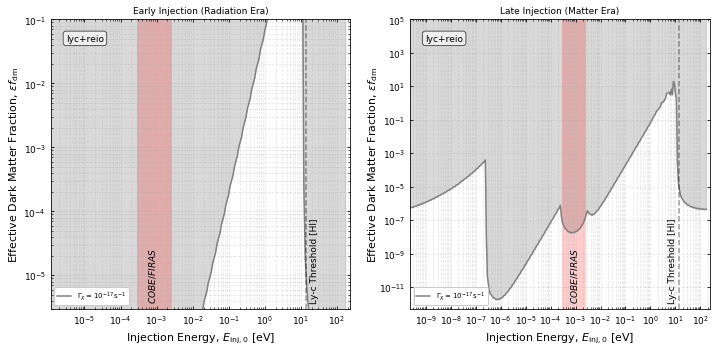

In [8]:
photon_injection_case = 'xe_history_200720'
photon_injection_case = 'lyc_reio'
#Gamma_values = np.logspace(-17,-8,3)
if photon_injection_case == 'bare':
    f_dm_fisher = f_dm_fisher_bare
    case = 'bare'
if photon_injection_case == 'lyc':
    f_dm_fisher = f_dm_fisher_lyc
    case = 'lyc'
if photon_injection_case == 'lyc_reio':
    f_dm_fisher = f_dm_fisher_lyc_reio
    case = 'lyc+reio'
if 'xe_history' in photon_injection_case:
    f_dm_fisher = f_dm_fisher_xe_history
    case = 'lyc+reio xe history'

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>','o','s','d','v','>'])
colors = iter(['grey','forestgreen','b','purple','k','r','b','green','grey'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
label_size = 9
title_size = 11
legend_size = 25
handle_length = 1.5

for ax in (ax1,ax2):
    ax.set_xscale('log')
    ax.set_yscale('log')


    ax.set_ylabel(label_fdm,size=title_size)
    ax.set_xlabel(label_injection_energy,size=title_size)
    ax.yaxis.set_label_coords(-.10,0.5)


    ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)

    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

    # manipulate x-axis ticks and labels
    ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True)

    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')

    
    
    #ax.axvspan(1.e-3*xinj_to_Einj, 2e-3*xinj_to_Einj,ymin=0.,ymax=0.1, facecolor='blue', alpha=0.2,label=r'$\mathrm{EDGES}$')
    #ax.axvspan(0.5*xinj_to_Einj, 105*xinj_to_Einj,ymin=0.,ymax=0.1,  facecolor='orange', alpha=0.2,label=r'$\mathrm{PIXIE}$')
    ax.axvspan(1.2*xinj_to_Einj, 11.2*xinj_to_Einj,ymin=0.,ymax=1, facecolor='red', alpha=0.2)
    
i = 0
color=iter(cm.viridis(np.linspace(0.7,0,len(Gamma_values))))
for gamma in np.flip(Gamma_values):
#     if i==0:
#         i += 1
#         continue
    col = next(colors)
    mk = next(mklist)
    ls = next(lstyles)
    #ax.plot(f_dm_high_z['curves'][i]['x'],f_dm_high_z['curves'][i]['mu'],c=col,label=r'$\Gamma_X=$'+scientific_notation(f_dm_high_z['Gamma_inj'][i])+r'$\,\mathrm{s^{-1}}$',ls='None', marker=mk,markersize=3)
    if i<5:
        ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],
                 c=col,label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=ls)#, marker=,markersize=3)
        ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],
                 c=col,ls=ls)#, marker=mk,markersize=3)
        ax1.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)
    if i<5:
        ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],
                 c=col,label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=ls)#, marker=mk,markersize=3,markerfacecolor='None')
        ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],
                 c=col,ls=ls)#, marker=mk,markersize=3,markerfacecolor='None')
        ax2.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)


    i += 1

ax2.text(0.05, 0.95, case , transform=ax2.transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

ax1.text(0.05, 0.95, case , transform=ax1.transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

ax1.set_ylim(3.e-6,1e-1)
ax1.set_xlim(xinj_to_Einj*5e-3,xinj_to_Einj*1e6)

ax2.set_ylim(5.e-13,1e5)
ax2.set_xlim(xinj_to_Einj*1e-6,xinj_to_Einj*1e6)

#leg1 = plt.legend(loc=3,ncol=2,frameon=True,framealpha=0.6,fontsize = 9)
#legend_elements = [Line2D([0], [0], marker='o', color='k', label='best-fit to CT',ls='None',
#                          markerfacecolor='None', markersize=5)]
#leg2 = plt.legend(handles=legend_elements, loc=(0.745,0.6))
ax1.legend(loc=3,ncol=1,frameon=True,framealpha=1.,fontsize = 7)
ax2.legend(loc=3,ncol=1,frameon=True,framealpha=1.,fontsize = 7)

if 'lyc' in photon_injection_case:
    ax2.axvline(5.7895e4*xinj_to_Einj,ls='--',alpha=0.4,c='k')
    ax2.text(0.86, 0.02, 'Ly-c Threshold [HI]' , transform=ax2.transAxes, fontsize=9,
             verticalalignment='bottom',rotation = 90)
    ax1.axvline(5.7895e4*xinj_to_Einj,ls='--',alpha=0.4,c='k')
    ax1.text(0.865, 0.02, 'Ly-c Threshold [HI]' , transform=ax1.transAxes, fontsize=9,
             verticalalignment='bottom',rotation = 90)
ax1.set_title(r'Early Injection (Radiation Era)',fontsize=9)
ax2.set_title(r'Late Injection (Matter Era)',fontsize=9)
ax1.text(0.322, 0.02, r'$COBE/FIRAS$' , transform=ax1.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
ax2.text(0.53, 0.02, r'$COBE/FIRAS$' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
# ax.add_artist(leg2).tight_layout(pad=3.0)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)

plt.savefig(path_to_figures + '/figures_for_paper_fdm_fisher_'+photon_injection_case+'.pdf')
plt.show()
#plt.close(fig)

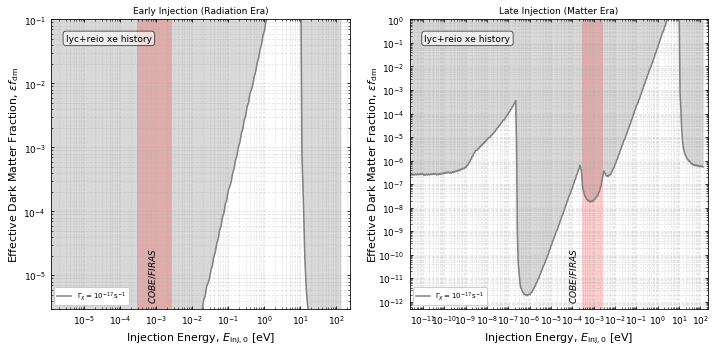

In [7]:
photon_injection_case = 'xe_history_200720'
#photon_injection_case = 'lyc_reio'
#Gamma_values = np.logspace(-17,-8,3)
if photon_injection_case == 'bare':
    f_dm_fisher = f_dm_fisher_bare
    case = 'bare'
if photon_injection_case == 'lyc':
    f_dm_fisher = f_dm_fisher_lyc
    case = 'lyc'
if photon_injection_case == 'lyc_reio':
    f_dm_fisher = f_dm_fisher_lyc_reio
    case = 'lyc+reio'
if 'xe_history' in photon_injection_case:
    f_dm_fisher = f_dm_fisher_xe_history
    case = 'lyc+reio xe history'

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>','o','s','d','v','>'])
colors = iter(['grey','forestgreen','b','purple','k','r','b','green','grey'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
label_size = 9
title_size = 11
legend_size = 25
handle_length = 1.5

for ax in (ax1,ax2):
    ax.set_xscale('log')
    ax.set_yscale('log')


    ax.set_ylabel(label_fdm,size=title_size)
    ax.set_xlabel(label_injection_energy,size=title_size)
    ax.yaxis.set_label_coords(-.10,0.5)


    ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)

    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

    # manipulate x-axis ticks and labels
    ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True)

    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')

    
    
    #ax.axvspan(1.e-3*xinj_to_Einj, 2e-3*xinj_to_Einj,ymin=0.,ymax=0.1, facecolor='blue', alpha=0.2,label=r'$\mathrm{EDGES}$')
    #ax.axvspan(0.5*xinj_to_Einj, 105*xinj_to_Einj,ymin=0.,ymax=0.1,  facecolor='orange', alpha=0.2,label=r'$\mathrm{PIXIE}$')
    ax.axvspan(1.2*xinj_to_Einj, 11.2*xinj_to_Einj,ymin=0.,ymax=1, facecolor='red', alpha=0.2)
    
i = 0
color=iter(cm.viridis(np.linspace(0.7,0,len(Gamma_values))))
for gamma in np.flip(Gamma_values):
#     if i==0:
#         i += 1
#         continue
    col = next(colors)
    mk = next(mklist)
    ls = next(lstyles)
    #ax.plot(f_dm_high_z['curves'][i]['x'],f_dm_high_z['curves'][i]['mu'],c=col,label=r'$\Gamma_X=$'+scientific_notation(f_dm_high_z['Gamma_inj'][i])+r'$\,\mathrm{s^{-1}}$',ls='None', marker=mk,markersize=3)
    if i<5:
        ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],
                 c=col,label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=ls)#, marker=,markersize=3)
        ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],
                 c=col,ls=ls)#, marker=mk,markersize=3)
        ax1.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)
    if i<5:
        ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],
                 c=col,label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=ls)#, marker=mk,markersize=3,markerfacecolor='None')
        ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],
                 c=col,ls=ls)#, marker=mk,markersize=3,markerfacecolor='None')
        ax2.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)


    i += 1

ax2.text(0.05, 0.95, case , transform=ax2.transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

ax1.text(0.05, 0.95, case , transform=ax1.transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

ax1.set_ylim(3.e-6,1e-1)
ax1.set_xlim(xinj_to_Einj*5e-3,xinj_to_Einj*1e6)

ax2.set_ylim(5.e-13,1e0)
ax2.set_xlim(xinj_to_Einj*1e-8,xinj_to_Einj*1e6)

#leg1 = plt.legend(loc=3,ncol=2,frameon=True,framealpha=0.6,fontsize = 9)
#legend_elements = [Line2D([0], [0], marker='o', color='k', label='best-fit to CT',ls='None',
#                          markerfacecolor='None', markersize=5)]
#leg2 = plt.legend(handles=legend_elements, loc=(0.745,0.6))
ax1.legend(loc=3,ncol=1,frameon=True,framealpha=1.,fontsize = 7)
ax2.legend(loc=3,ncol=1,frameon=True,framealpha=1.,fontsize = 7)

if 'lyc' in photon_injection_case:
    ax2.axvline(5.7895e4*xinj_to_Einj,ls='--',alpha=0.4,c='k')
    ax2.text(0.86, 0.02, 'Ly-c Threshold [HI]' , transform=ax2.transAxes, fontsize=9,
             verticalalignment='bottom',rotation = 90)
    ax1.axvline(5.7895e4*xinj_to_Einj,ls='--',alpha=0.4,c='k')
    ax1.text(0.865, 0.02, 'Ly-c Threshold [HI]' , transform=ax1.transAxes, fontsize=9,
             verticalalignment='bottom',rotation = 90)
ax1.set_title(r'Early Injection (Radiation Era)',fontsize=9)
ax2.set_title(r'Late Injection (Matter Era)',fontsize=9)
ax1.text(0.322, 0.02, r'$COBE/FIRAS$' , transform=ax1.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
ax2.text(0.53, 0.02, r'$COBE/FIRAS$' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
# ax.add_artist(leg2).tight_layout(pad=3.0)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)

plt.savefig(path_to_figures + '/figures_for_paper_fdm_fisher_'+photon_injection_case+'.pdf')
plt.show()
#plt.close(fig)

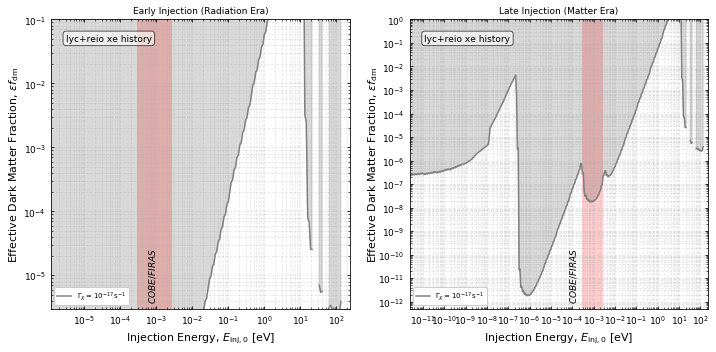

In [9]:
photon_injection_case = 'xe_history_200720_finj_fisher'
#photon_injection_case = 'lyc_reio'
#Gamma_values = np.logspace(-17,-8,3)
if photon_injection_case == 'bare':
    f_dm_fisher = f_dm_fisher_bare
    case = 'bare'
if photon_injection_case == 'lyc':
    f_dm_fisher = f_dm_fisher_lyc
    case = 'lyc'
if photon_injection_case == 'lyc_reio':
    f_dm_fisher = f_dm_fisher_lyc_reio
    case = 'lyc+reio'
if 'xe_history' in photon_injection_case:
    f_dm_fisher = f_dm_fisher_xe_history_finj_fisher
    case = 'lyc+reio xe history'

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>','o','s','d','v','>'])
colors = iter(['grey','forestgreen','b','purple','k','r','b','green','grey'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
label_size = 9
title_size = 11
legend_size = 25
handle_length = 1.5

for ax in (ax1,ax2):
    ax.set_xscale('log')
    ax.set_yscale('log')


    ax.set_ylabel(label_fdm,size=title_size)
    ax.set_xlabel(label_injection_energy,size=title_size)
    ax.yaxis.set_label_coords(-.10,0.5)


    ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)

    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

    # manipulate x-axis ticks and labels
    ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True)

    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')

    
    
    #ax.axvspan(1.e-3*xinj_to_Einj, 2e-3*xinj_to_Einj,ymin=0.,ymax=0.1, facecolor='blue', alpha=0.2,label=r'$\mathrm{EDGES}$')
    #ax.axvspan(0.5*xinj_to_Einj, 105*xinj_to_Einj,ymin=0.,ymax=0.1,  facecolor='orange', alpha=0.2,label=r'$\mathrm{PIXIE}$')
    ax.axvspan(1.2*xinj_to_Einj, 11.2*xinj_to_Einj,ymin=0.,ymax=1, facecolor='red', alpha=0.2)
    
i = 0
color=iter(cm.viridis(np.linspace(0.7,0,len(Gamma_values))))
for gamma in np.flip(Gamma_values):
#     if i==0:
#         i += 1
#         continue
    col = next(colors)
    mk = next(mklist)
    ls = next(lstyles)
    #ax.plot(f_dm_high_z['curves'][i]['x'],f_dm_high_z['curves'][i]['mu'],c=col,label=r'$\Gamma_X=$'+scientific_notation(f_dm_high_z['Gamma_inj'][i])+r'$\,\mathrm{s^{-1}}$',ls='None', marker=mk,markersize=3)
    if i<5:
        ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],
                 c=col,label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=ls)#, marker=,markersize=3)
        ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],
                 c=col,ls=ls)#, marker=mk,markersize=3)
        ax1.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)
    if i<5:
        ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],
                 c=col,label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=ls)#, marker=mk,markersize=3,markerfacecolor='None')
        ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],
                 c=col,ls=ls)#, marker=mk,markersize=3,markerfacecolor='None')
        ax2.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)


    i += 1

ax2.text(0.05, 0.95, case , transform=ax2.transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

ax1.text(0.05, 0.95, case , transform=ax1.transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

ax1.set_ylim(3.e-6,1e-1)
ax1.set_xlim(xinj_to_Einj*5e-3,xinj_to_Einj*1e6)

ax2.set_ylim(5.e-13,1e0)
ax2.set_xlim(xinj_to_Einj*1e-8,xinj_to_Einj*1e6)

#leg1 = plt.legend(loc=3,ncol=2,frameon=True,framealpha=0.6,fontsize = 9)
#legend_elements = [Line2D([0], [0], marker='o', color='k', label='best-fit to CT',ls='None',
#                          markerfacecolor='None', markersize=5)]
#leg2 = plt.legend(handles=legend_elements, loc=(0.745,0.6))
ax1.legend(loc=3,ncol=1,frameon=True,framealpha=1.,fontsize = 7)
ax2.legend(loc=3,ncol=1,frameon=True,framealpha=1.,fontsize = 7)

if 'lyc' in photon_injection_case:
    ax2.axvline(5.7895e4*xinj_to_Einj,ls='--',alpha=0.4,c='k')
    ax2.text(0.86, 0.02, 'Ly-c Threshold [HI]' , transform=ax2.transAxes, fontsize=9,
             verticalalignment='bottom',rotation = 90)
    ax1.axvline(5.7895e4*xinj_to_Einj,ls='--',alpha=0.4,c='k')
    ax1.text(0.865, 0.02, 'Ly-c Threshold [HI]' , transform=ax1.transAxes, fontsize=9,
             verticalalignment='bottom',rotation = 90)
ax1.set_title(r'Early Injection (Radiation Era)',fontsize=9)
ax2.set_title(r'Late Injection (Matter Era)',fontsize=9)
ax1.text(0.322, 0.02, r'$COBE/FIRAS$' , transform=ax1.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
ax2.text(0.53, 0.02, r'$COBE/FIRAS$' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
# ax.add_artist(leg2).tight_layout(pad=3.0)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)

plt.savefig(path_to_figures + '/figures_for_paper_fdm_fisher_'+photon_injection_case+'.pdf')
plt.show()
#plt.close(fig)

In [105]:
sd_lib_xe_history.finj_2d[0][0][0]

8.33180319e-07

In [111]:
np.shape(sd_lib_xe_history.finj_2d)
sd_lib_xe_history.finj_2d[0][0]

[8.33180319e-07,
 8.60581436e-07,
 8.88658322e-07,
 9.17651245e-07,
 9.47590091e-07,
 9.78505725e-07,
 1.01043001e-06,
 1.04339587e-06,
 1.07743728e-06,
 1.11258932e-06,
 1.14888825e-06,
 1.18637148e-06,
 1.22507765e-06,
 1.26504666e-06,
 1.30631971e-06,
 1.34893936e-06,
 1.39294954e-06,
 1.43839563e-06,
 1.48532446e-06,
 1.53378443e-06,
 1.58382549e-06,
 1.63549922e-06,
 1.68885891e-06,
 1.74395956e-06,
 1.80085798e-06,
 1.85961283e-06,
 1.92028467e-06,
 1.98293607e-06,
 2.04763161e-06,
 2.114438e-06,
 2.1834241e-06,
 2.25466105e-06,
 2.32822228e-06,
 2.40418365e-06,
 2.48262347e-06,
 2.5636226e-06,
 2.64726457e-06,
 2.73363561e-06,
 2.82282478e-06,
 2.91492403e-06,
 3.01002833e-06,
 3.10823574e-06,
 3.20964751e-06,
 3.31436821e-06,
 3.42250582e-06,
 3.53417185e-06,
 3.64948144e-06,
 3.76855348e-06,
 3.89151077e-06,
 4.01848008e-06,
 4.14959236e-06,
 4.28498281e-06,
 4.42479103e-06,
 4.56916121e-06,
 4.71824223e-06,
 4.87218783e-06,
 5.03115677e-06,
 5.195313e-06,
 5.36482581e-06,
 5.

In [108]:
np.shape(sd_lib_lyc_reio.finj_2d)
sd_lib_lyc_reio.finj_2d[0][0]

[289.7]

In [106]:
def find_nearests(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if array[idx]>value:
        idxp =idx
        idxm = idx-1
    else:
        idxm = idx
        idxp = idx+1
    if idxp == len(array):
        idxm -= 1
        idxp -= 1
    return (idxm,idxp)

def GetSpectra(Gamma_inj_asked,x_inj_asked,x_asked,specdist_ct_spectra_lib):
    r1 = (Gamma_inj_asked - specdist_ct_spectra_lib.Gamma_inj_min)
    r2 = (specdist_ct_spectra_lib.Gamma_inj_max - Gamma_inj_asked)
    r3 = (x_inj_asked - specdist_ct_spectra_lib.x_inj_min)
    r4 = (specdist_ct_spectra_lib.x_inj_max - x_inj_asked)

    if (r1 < 0) or (r2 < 0) or (r3 < 0) or (r4 < 0):
        print('filling with nans')
        array_x_asked =  np.empty(len(x_asked))
        array_x_asked[:] = np.nan
        array_S_result = np.empty(len(x_asked))
        array_S_result[:] =  np.nan
        F_gamma_asked_xinj_asked = np.nan

    else:
        X_2d =  specdist_ct_spectra_lib.X_2d
        DI_2d = specdist_ct_spectra_lib.DI_2d
        finj_2d = specdist_ct_spectra_lib.finj_2d

        Gamma_values = specdist_ct_spectra_lib.Gamma_values
        x_inj_values =  specdist_ct_spectra_lib.x_inj_values
        # print(Gamma_values)
        # print(x_inj_values)
        # print(find_nearests(Gamma_values, Gamma_inj_asked))
        id_gamma_low = find_nearests(Gamma_values, Gamma_inj_asked)[0]
        id_gamma_high = find_nearests(Gamma_values, Gamma_inj_asked)[1]
#         if id_gamma_low == -1 and id_gamma_high == 0:
#             id_gamma_low = id_gamma_high

        id_xinj_low = find_nearests(x_inj_values, x_inj_asked)[0]
        id_xinj_high = find_nearests(x_inj_values, x_inj_asked)[1]
        
        print(id_gamma_low,id_gamma_high,id_xinj_low,id_xinj_high)

        #DI_2d[id_gamma_low][id_xinj_low]  #DI_2d[id_gamma_low][id_xinj_high]
        #X_2d[id_gamma_low][id_xinj_low]   #X_2d[id_gamma_low][id_xinj_high]

        #DI_2d[id_gamma_high][id_xinj_low]  #DI_2d[id_gamma_high][id_xinj_high]
        #X_2d[id_gamma_high][id_xinj_low]   #X_2d[id_gamma_high][id_xinj_high]
        S = [[X_2d[id_gamma_low][id_xinj_low],DI_2d[id_gamma_low][id_xinj_low]],[X_2d[id_gamma_low][id_xinj_high],DI_2d[id_gamma_low][id_xinj_high]],[X_2d[id_gamma_high][id_xinj_low],DI_2d[id_gamma_high][id_xinj_low]],[X_2d[id_gamma_high][id_xinj_high],DI_2d[id_gamma_high][id_xinj_high]]]
        F = [finj_2d[id_gamma_low][id_xinj_low],
             finj_2d[id_gamma_low][id_xinj_high],
             finj_2d[id_gamma_high][id_xinj_low],
             finj_2d[id_gamma_high][id_xinj_high]]
        dict = {
        "gamma_low": Gamma_values[id_gamma_low],
        "gamma_high": Gamma_values[id_gamma_high],
        "xinj_low": x_inj_values[id_xinj_low],
        "xinj_high": x_inj_values[id_xinj_high],
        "spectra": S,
        "finj": F
        }
        
        #print(F)

        gamma_low = dict["gamma_low"]
        gamma_high = dict["gamma_high"]
        xinj_low = dict["xinj_low"]
        xinj_high = dict["xinj_high"]
        S = dict["spectra"]
        F = dict["finj"]
        
        #print(gamma_low)
        #print(gamma_high)

        S_gamma_low_xinj_low = S[0]
        S_gamma_low_xinj_high = S[1]
        S_gamma_high_xinj_low = S[2]
        S_gamma_high_xinj_high = S[3]

        F_gamma_low_xinj_low = F[0][0]
        F_gamma_low_xinj_high = F[1][0]
        F_gamma_high_xinj_low = F[2][0]
        F_gamma_high_xinj_high = F[3][0]

        Gamma_asked = Gamma_inj_asked
        xinj_asked = x_inj_asked

        #check if nan in any of the arrays:
        Arrays_list = [S_gamma_low_xinj_low,
                      S_gamma_low_xinj_high,
                      S_gamma_high_xinj_low,
                      S_gamma_high_xinj_high]
        has_nan = False
        for p in Arrays_list:
            array = p
            array_sum = np.sum(array)
            has_nan += np.isnan(array_sum)
        if has_nan:
            #print('filling with nans')
            array_x_asked =  np.empty(len(x_asked))
            array_x_asked[:] = np.nan
            array_S_result = np.empty(len(x_asked))
            array_S_result[:] =  np.nan
            F_gamma_asked_xinj_asked = np.nan
        else:
            nx = int(1e4)


            ############### xinj_low
            new_x_min = np.maximum(np.min(S_gamma_low_xinj_low[0]),np.min(S_gamma_high_xinj_low[0]))
            new_x_max = np.minimum(np.max(S_gamma_low_xinj_low[0]),np.max(S_gamma_high_xinj_low[0]))
            new_x_array = np.logspace(np.log10(new_x_min),np.log10(new_x_max),nx)
            new_x_array = new_x_array[1:-1]


            f_gamma_low = interp1d(S_gamma_low_xinj_low[0], S_gamma_low_xinj_low[1])
            f_gamma_high = interp1d(S_gamma_high_xinj_low[0], S_gamma_high_xinj_low[1])

            new_S_gamma_low = f_gamma_low(new_x_array)
            new_S_gamma_high = f_gamma_high(new_x_array)

            if gamma_low == Gamma_asked:
                w = 1.
            elif gamma_high == Gamma_asked:
                w = 0.
            else:
                #w = (gamma_high - Gamma_asked)/(gamma_high - gamma_low)
                w = (np.log(gamma_high) - np.log(Gamma_asked))/(np.log(gamma_high) - np.log(gamma_low))
            new_S_gamma_asked = w*new_S_gamma_low + (1.-w)*new_S_gamma_high
#             print('xinj _low : w_gamma = %.14e'%w)



            S_gamma_asked_xinj_low = [[],[]]
            S_gamma_asked_xinj_low[0] = new_x_array
            S_gamma_asked_xinj_low[1] = new_S_gamma_asked
            
            print('w=%.4e'%w)
            print('gamma_low= %.4e'%gamma_low)
            print('gamma_high= %.4e'%gamma_high)
            print('F_gamma_low_xinj_low= %.4e'%F_gamma_low_xinj_low)
            print('F_gamma_high_xinj_low= %.4e'%F_gamma_high_xinj_low)
            F_gamma_asked_xinj_low = w*F_gamma_low_xinj_low + (1.-w)*F_gamma_high_xinj_low
            print('F_gamma_asked_xinj_low=%.4e'%F_gamma_asked_xinj_low)
            ############# xinj_high

            new_x_min = np.maximum(np.min(S_gamma_low_xinj_high[0]),np.min(S_gamma_high_xinj_high[0]))
            new_x_max = np.minimum(np.max(S_gamma_low_xinj_high[0]),np.max(S_gamma_high_xinj_high[0]))
            new_x_array = np.logspace(np.log10(new_x_min),np.log10(new_x_max),nx)
            new_x_array = new_x_array[1:-1]

            f_gamma_low = interp1d(S_gamma_low_xinj_high[0], S_gamma_low_xinj_high[1])
            f_gamma_high = interp1d(S_gamma_high_xinj_high[0], S_gamma_high_xinj_high[1])

            new_S_gamma_low = f_gamma_low(new_x_array)
            new_S_gamma_high = f_gamma_high(new_x_array)

            if gamma_low == Gamma_asked:
                w = 1.
            elif gamma_high == Gamma_asked:
                w = 0.
            else:
                #w = (gamma_high - Gamma_asked)/(gamma_high - gamma_low)
                w = (np.log(gamma_high) - np.log(Gamma_asked))/(np.log(gamma_high) - np.log(gamma_low))
#             #w = (gamma_high - Gamma_asked)/(gamma_high - gamma_low)
#             w = (np.log(gamma_high) - np.log(Gamma_asked))/(np.log(gamma_high) - np.log(gamma_low))
            new_S_gamma_asked = w*new_S_gamma_low + (1.-w)*new_S_gamma_high
#             print('xinj _high : w_gamma = %.14e'%w)

            S_gamma_asked_xinj_high = [[],[]]
            S_gamma_asked_xinj_high[0] = new_x_array
            S_gamma_asked_xinj_high[1] = new_S_gamma_asked

            F_gamma_asked_xinj_high = w*F_gamma_low_xinj_low + (1.-w)*F_gamma_high_xinj_high

            ############# interpolation between xinjs
            new_x_min = np.maximum(np.min(S_gamma_asked_xinj_low[0]),np.min(S_gamma_asked_xinj_high[0]))
            new_x_max = np.minimum(np.max(S_gamma_asked_xinj_low[0]),np.max(S_gamma_asked_xinj_high[0]))
            new_x_array = np.logspace(np.log10(new_x_min),np.log10(new_x_max),nx)
            new_x_array = new_x_array[1:-1]

            f_xinj_low = interp1d(S_gamma_asked_xinj_low[0], S_gamma_asked_xinj_low[1])
            f_xinj_high = interp1d(S_gamma_asked_xinj_high[0], S_gamma_asked_xinj_high[1])

            new_S_xinj_low = f_xinj_low(new_x_array)
            new_S_xinj_high = f_xinj_high(new_x_array)

            #w = (xinj_high - xinj_asked)/(xinj_high - xinj_low)
            w = (np.log(xinj_high) - np.log(xinj_asked))/(np.log(xinj_high) - np.log(xinj_low))
#             print('xinj_high = %.14e'%xinj_high)
#             print('w_xinj = %.14e'%w)
            
            new_S_xinj_asked = w*new_S_xinj_low + (1.-w)*new_S_xinj_high

            S_gamma_asked_xinj_asked = [[],[]]
            S_gamma_asked_xinj_asked[0] = new_x_array
            S_gamma_asked_xinj_asked[1] = new_S_xinj_asked

            F_gamma_asked_xinj_asked = w*F_gamma_asked_xinj_low + (1.-w)*F_gamma_asked_xinj_high


            f_gamma_asked_xinj_asked = interp1d(S_gamma_asked_xinj_asked[0], S_gamma_asked_xinj_asked[1])
            ########### get spectra at required x values
            bound_x_min = np.min(S_gamma_asked_xinj_asked[0])
            bound_x_max = np.max(S_gamma_asked_xinj_asked[0])

            array_x_asked = np.asarray(x_asked)

            min_x_asked = np.min(array_x_asked)
            max_x_asked = np.max(array_x_asked)

            id_min = 0
            id_max = None
            if min_x_asked < bound_x_min:
                id_min = find_nearests(array_x_asked, bound_x_min)[1]
            if max_x_asked > bound_x_max:
                id_max = find_nearests(array_x_asked, bound_x_max)[0]
            array_x_asked = array_x_asked[id_min:id_max]

            array_S_result = f_gamma_asked_xinj_asked(array_x_asked)

    r_dict = {"x":array_x_asked,
              "DI": array_S_result,
              "finj": F_gamma_asked_xinj_asked}

    return r_dict



0 1 33 34
w=1.0000e+00
gamma_low= 1.0000e-17
gamma_high= 1.5264e-17
F_gamma_low_xinj_low= 2.9650e+00
F_gamma_high_xinj_low= 3.8280e+00
F_gamma_asked_xinj_low=2.9650e+00
-1 0 53 54
w=1.0000e+00
gamma_low= 1.0000e-17
gamma_high= 1.0000e-17
F_gamma_low_xinj_low= 2.2249e-03
F_gamma_high_xinj_low= 2.2249e-03
F_gamma_asked_xinj_low=2.2249e-03
2.965
0.00222493482


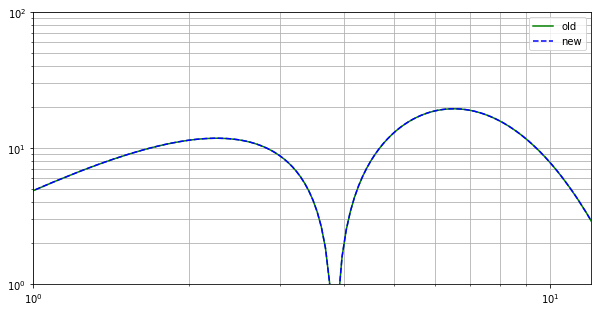

In [107]:
i=32

x_asked = np.logspace(np.log10(1e-5),np.log10(1e3),1000)
gamma_asked = 1.e-17
# xinj_asked = 7.19685673001151e-01
xinj_asked = 1.e-4
# new runs 6.449e+05
#xinj_old_run i = 189 #249451
# S_bare = pi.GetSpectra(gamma_asked,xinj_asked,x_asked,sd_lib_bare)
# S_mu_fit = pi.GetSpectra(gamma_asked,xinj_asked,x_asked,sd_lib_mu_fit)
S_lyc_reio = GetSpectra(gamma_asked,xinj_asked,x_asked,sd_lib_lyc_reio)
S_xe_history = GetSpectra(gamma_asked,xinj_asked,x_asked,sd_lib_xe_history)

fig, (ax) = plt.subplots(1,1,figsize=(10,5))
# S = S_bare
# plt.plot(S['x'],np.abs(S['DI']),c='k',label='bare')
# S = S_mu_fit
# plt.plot(S['x'],np.abs(S['DI']),c='r',label = 'mu_fit',ls='--')
S = S_lyc_reio
print(S['finj'])
plt.plot(S['x'],np.abs(S['DI']),c='g',label = 'old',ls='-')
S = S_xe_history
print(S['finj'])

# plt.plot(x_ct[26],np.abs(DI_ct_bare[26]),c='r',label = 'tot',ls='-.')
# plt.plot(x_ct[26],np.abs(DI_ct_hubble[26]),c='k',label = 'hubble-reio',ls='-.')
# # plt.plot(x_ct[26],np.abs(DI_ct_bare[26]-DI_ct_hubble[26]),c='orange',label = 'bare',ls='-.')
plt.plot(S['x'],np.abs(S['DI']),c='b',label = 'new',ls='--')
# plt.plot(x_ct[i],DI_ct[i],c='orange',label = 'i',ls='-',
#            marker='o',markersize=0.1)
# plt.plot(x_ct[i+1],DI_ct[i+1],c='r',label = 'i+1',ls='-',
#            marker='o',markersize=0.1)

# plt.plot(S['x'],-S['DI'],c='b',label = 'interp',ls=':')
# plt.plot(x_ct[i],-DI_ct[i],c='orange',label = 'i',ls=':',
#            marker='o',markersize=0.1)
# plt.plot(x_ct[i+1],-DI_ct[i+1],c='r',label = 'i+1',ls=':',
#            marker='o',markersize=0.1)

# # plt.plot(x_ct[26],np.abs(DI_ct_hubble[26]),c='k',label = 'bare',ls='-.')
#plt.plot(CT_X_new,np.abs(CT_I_new),c='magenta',label = 'ct new',ls='-')
#plt.plot(CT_X_old,np.abs(CT_I_old),c='r',label = 'ct old',ls='-.')
#plt.plot(CT_X_sirius,np.abs(CT_I_sirius),c='orange',label = 'sirius',ls='-.')
plt.loglog()
plt.grid(which='both')
plt.ylim(1e0,1e2)
plt.xlim(1e0,1.2e1)
plt.legend(loc=1)
#plt.savefig(path_to_figures + '/figures_for_paper_tests.pdf')



In [49]:
strg = "1.000e-17"

DI_ct = []
DI_ct_bare = []
DI_ct_hubble = []
DI_ct_bare_final = []
DI_ct_hubble_final = []
filename = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/ct_database/case_xe_history_180720/xe_history_180720_G_'+strg+'/spectra_xe_history_180720_G_'+strg+'_DI_ct.txt'
filename_hubble ='/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/ct_database/case_xe_history_180720/xe_history_180720_hubble_G_'+strg+'/spectra_xe_history_180720_hubble_G_'+strg+'_DI_ct.txt'
with open(filename) as f:
    for line in f:
        ls = line.strip()
        if ls:
            if "#" in ls:
                continue
            else:
                DI_ct_p = []
                l = re.split('\t',ls)
                l = [e for e in l if e]
                #print(l)
                for s in l:
                    DI_cti = float(s)
                    DI_ct_p.append(DI_cti)
                DI_ct_p = np.asarray(DI_ct_p)
            DI_ct_bare.append(DI_ct_p)
with open(filename_hubble) as f:
    for line in f:
        ls = line.strip()
        if ls:
            if "#" in ls:
                continue
            else:
                DI_ct_p = []
                l = re.split('\t',ls)
                l = [e for e in l if e]
                #print(l)
                for s in l:
                    DI_cti = float(s)
                    DI_ct_p.append(DI_cti)
                DI_ct_p = np.asarray(DI_ct_p)
            DI_ct_hubble.append(DI_ct_p)
for (p_bare,p_hubble) in zip(DI_ct_bare,DI_ct_hubble):
    DI_ct.append(p_bare-p_hubble)
    DI_ct_hubble_final.append(p_hubble)
    DI_ct_bare_final.append(p_bare)

#read x array
x_ct = []
filename = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/ct_database/case_xe_history_180720/xe_history_180720_G_'+strg+'/spectra_xe_history_180720_G_'+strg+'_x_ct.txt'
with open(filename) as f:
    for line in f:
        ls = line.strip()
        if ls:
            if "#" in ls:
                continue
            else:
                x_ct_p = []
                l = re.split('\t',ls)
                l = [e for e in l if e]
                #print(l)
                for s in l:
                    x_cti = float(s)
                    x_ct_p.append(x_cti)
                x_ct_p = np.asarray(x_ct_p)
            x_ct.append(x_ct_p)

In [24]:
CT_hubble = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/cosmotherm.rel_corr/outputs/Dn.cooling.photon_inj.PDE_ODE.new_state.hubble.tmp.dat')
CT = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/cosmotherm.rel_corr/outputs/Dn.cooling.photon_inj.PDE_ODE.new_state.tmp.dat')

CT_I_new = CT[:,5]-CT_hubble[:,5]
CT_X_new = CT[:,0]

CT_hubble = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/cosmotherm.rel_corr/outputs/Dn.cooling.photon_inj.PDE_ODE.old_state.hubble.tmp.dat')
CT = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/cosmotherm.rel_corr/outputs/Dn.cooling.photon_inj.PDE_ODE.old_state.tmp.dat')

CT_I_old = CT[:,5]-CT_hubble[:,5]
CT_X_old = CT[:,0]



In [50]:
x_inj = []
filename = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/ct_database/case_xe_history_180720/xe_history_180720_G_'+strg+'/spectra_xe_history_180720_G_'+strg+'_xinj_ct.txt'
with open(filename) as f:
    for line in f:
        ls = line.strip()
        if ls:
            if "#" in ls:
                continue
            else:
                x_ct_p = []
                l = re.split('\t',ls)
                l = [e for e in l if e]
                #print(l)
                for s in l:
                    x_cti = float(s)
                    x_ct_p.append(x_cti)
                x_ct_p = np.asarray(x_ct_p)
            x_inj.append(x_ct_p[0])
#x_inj

In [51]:
x_inj[32]

0.416

In [57]:
x_inj[33]

0.7197

In [10]:
sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)

In [15]:
ct = pi.cosmotherm()
ct.ct_Drho_rho_dec = 3e-5
# ct.ct_h = 0.70
# ct.ct_Omega_b = 0.0457
# ct.ct_Omega_m = 0.30
cosmo = pi.cosmo()
X_dm = pi.dm_particle()
pi.set_dm_params_to_CT_pi_params(X_dm,ct)
pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)


xi_array = np.logspace(np.log10(1e1),np.log10(1.e8),200)
Gamma_inj_min = 1e-8
Gamma_inj_max = 1e-6
N_Gamma_inj = 4
#Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)
Gamma_values = [1e-8,5e-8,1e-7,5e-7,1e-6]
gamma_labels = [r'$10^{-8}$',r'$5\times10^{-8}$',r'$10^{-7}$',r'$5\times10^{-7}$',r'$10^{-6}$']
f_dm_high_z = {}
f_dm_high_z['curves'] = []
f_dm_high_z['Gamma_inj'] = []




for gamma in Gamma_values:
    mu_high_z = {}
    mu_high_z['x'] = xi_array
    mui = []
    for xi in xi_array:
        X_dm.x_0 = xi
        X_dm.Gamma_inj = gamma
        #X_dm.f_dm = pi.get_fdm_from_Drho_rho(ct.ct_Drho_rho_dec,cosmo,ct,X_dm)['tot']
        #print(r)
        mui.append(pi.high_redshift_f_dm_limit(9e-5,cosmo,ct,X_dm,N_int = 5))
    mu_high_z['mu'] = np.asarray(mui)
    f_dm_high_z['curves'].append(mu_high_z)
    f_dm_high_z['Gamma_inj'].append(gamma)



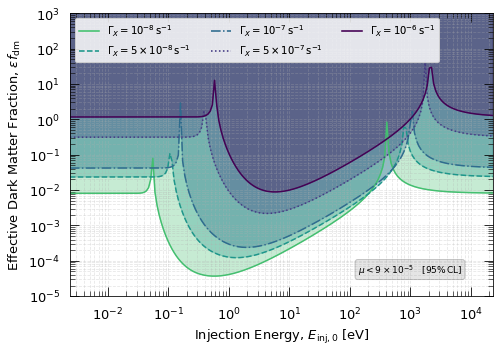

In [17]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 13
title_size = 13
legend_size = 25
handle_length = 1.5



# ymin=1e-6
# ymax = 2e-2
# x_min = 1e1
# x_max = 1e8
# ax.set_xlim(x_min,x_max)
# ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_ylabel(label_fdm,size=title_size)
ax.set_xlabel(label_injection_energy,size=title_size)
ax.yaxis.set_label_coords(-.11,0.5)


ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(True) #(3)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=5)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=5)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)

# manipulate x-axis ticks and labels
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(True) #(3)

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
i = 0
color=iter(cm.viridis(np.linspace(0.7,0,len(Gamma_values))))
for gamma in np.flip(Gamma_values):
    col = next(color)
    lst = next(lstyles)
    mk = next(mklist)
    ax.plot(xinj_to_Einj*f_dm_high_z['curves'][i]['x'],np.abs(f_dm_high_z['curves'][i]['mu']),c=col,label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=lst)#, marker=mk,markersize=3)


    ax.fill_between(xinj_to_Einj*f_dm_high_z['curves'][i]['x'], np.abs(f_dm_high_z['curves'][i]['mu']),1e100,color=col,alpha=0.3)


    i += 1


ax.text(0.68, 0.12, r'$\mu < 9\times10^{-5}\quad$' + r'$[95\%\,\mathrm{CL}]$' , transform=ax.transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='grey', alpha=0.2))


plt.ylim(1.e-5,1e3)
plt.xlim(xinj_to_Einj*1e1,xinj_to_Einj*1e8)

leg1 = plt.legend(loc=2,ncol=3,frameon=True,framealpha=0.6,fontsize = 10)
legend_elements = [Line2D([0], [0], marker='o', color='k', label='best-fit to CT',ls='None',
                          markerfacecolor='None', markersize=5)]
#leg2 = plt.legend(handles=legend_elements, loc=(0.745,0.6))
ax.add_artist(leg1)
# ax.add_artist(leg2)
fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_fdm_high_z.pdf')
plt.show()
plt.close(fig)

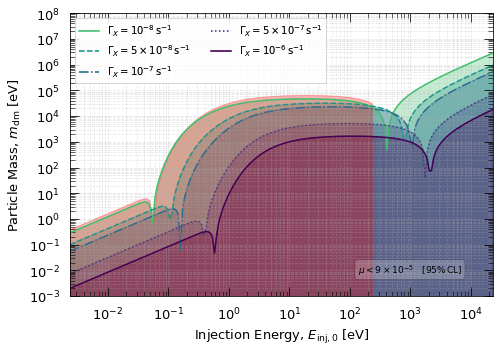

In [86]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 13
title_size = 13
legend_size = 25
handle_length = 1.5


Gamma_values = [1e-8,5e-8,1e-7,5e-7,1e-6]
gamma_labels = [r'$10^{-8}$',r'$5\times10^{-8}$',r'$10^{-7}$',r'$5\times10^{-7}$',r'$10^{-6}$']
# ymin=1e-6
# ymax = 2e-2
# x_min = 1e1
# x_max = 1e8
# ax.set_xlim(x_min,x_max)
# ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_ylabel(label_mdm,size=title_size)
ax.set_xlabel(label_injection_energy,size=title_size)
ax.yaxis.set_label_coords(-.11,0.5)


ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(True) #(3)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=5)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=5)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)

# manipulate x-axis ticks and labels
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(True) #(3)

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
i = 0
color=iter(cm.viridis(np.linspace(0.7,0,len(Gamma_values))))
for gamma in np.flip(Gamma_values):
    col = next(color)
    lst = next(lstyles)
    #mk = next(mklist)
    ax.plot(xinj_to_Einj*f_dm_high_z['curves'][i]['x'],(np.abs(f_dm_high_z['curves'][i]['mu']/(xinj_to_Einj*f_dm_high_z['curves'][i]['x'])))**-1,c=col,label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=lst)#, marker=mk,markersize=3)


    ax.fill_between(xinj_to_Einj*f_dm_high_z['curves'][i]['x'], (np.abs(f_dm_high_z['curves'][i]['mu']/(xinj_to_Einj*f_dm_high_z['curves'][i]['x'])))**-1,1e-100,color=col,alpha=0.3)


    i += 1

f_dm_fisher=f_dm_fisher_lyc_reio_with_edges
ax.plot(xinj_to_Einj*f_dm_fisher['curves'][0]['x'],-(f_dm_fisher['curves'][0]['fdm']/(xinj_to_Einj*f_dm_fisher['curves'][0]['x']))**-1.,c='r',ls=style, marker='None')
ax.fill_between(xinj_to_Einj*f_dm_fisher['curves'][0]['x'], (np.abs(f_dm_fisher['curves'][0]['fdm'])/(xinj_to_Einj*f_dm_fisher['curves'][0]['x']))**-1,1e-100,color='r',alpha=0.3)


ax.text(0.68, 0.12, r'$\mu < 9\times10^{-5}\quad$' + r'$[95\%\,\mathrm{CL}]$' , transform=ax.transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.2))


plt.ylim(1.e-3,1e8)
plt.xlim(xinj_to_Einj*1e1,xinj_to_Einj*1e8)

leg1 = plt.legend(loc=2,ncol=2,frameon=True,framealpha=0.6,fontsize = 10)
legend_elements = [Line2D([0], [0], marker='o', color='k', label='best-fit to CT',ls='None',
                          markerfacecolor='None', markersize=5)]
#leg2 = plt.legend(handles=legend_elements, loc=(0.745,0.6))
ax.add_artist(leg1)
# ax.add_artist(leg2)
fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_mdm_high_z.pdf')
plt.show()
plt.close(fig)

In [85]:
f_dm_fisher['Gamma_inj']

[1e-08, 1e-09, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15, 1e-16, 1e-17]

In [47]:
sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)

In [48]:
Nx = 200
xi_array = np.logspace(-6,6,Nx)

Gamma_values = [1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15,1e-16,1e-17]
gamma_labels = [r'$10^{-8}$',r'$10^{-9}$',r'$10^{-10}$',r'$10^{-11}$',r'$10^{-12}$',r'$10^{-13}$',r'$10^{-14}$',r'$10^{-15}$',r'$10^{-16}$',r'$10^{-17}$']






firas = sd.firas()
edges = sd.edges()
a_dict = {}
a_dict['firas'] = firas
a_dict['edges'] = edges
a_dict['add_edges'] = 'yes'

f_dm_fisher_lyc_reio_with_edges = sd.pi_run_fisher_constraints(Gamma_values,xi_array,sd_lib_lyc_reio,**a_dict)

a_dict['add_edges'] = 'no'

f_dm_fisher_lyc_reio_no_edges = sd.pi_run_fisher_constraints(Gamma_values,xi_array,sd_lib_lyc_reio,**a_dict)



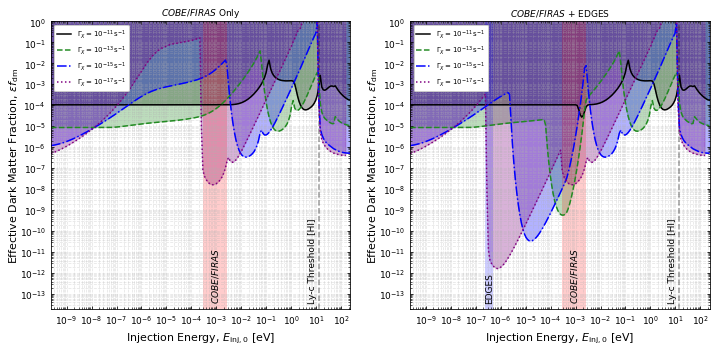

In [58]:
# photon_injection_case = 'bare'
# if photon_injection_case == 'bare':
#     f_dm_fisher = f_dm_fisher_bare
#     case = 'bare'
# if photon_injection_case == 'lyc':
#     f_dm_fisher = f_dm_fisher_lyc
#     case = 'lyc'
# if photon_injection_case == 'lyc_reio':
photon_injection_case = 'lyc_reio'
#     f_dm_fisher = f_dm_fisher_lyc_reio
#  
case = 'lyc+reio'

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>','o','s','d','v','>'])
colors = iter(['k','forestgreen','b','purple','green','magenta','r','b','orange','green','magenta'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
label_size = 9
title_size = 11
legend_size = 25
handle_length = 1.5

for ax in (ax1,ax2):
    ax.set_xscale('log')
    ax.set_yscale('log')


    ax.set_ylabel(label_fdm,size=title_size)
    ax.set_xlabel(label_injection_energy,size=title_size)
    ax.yaxis.set_label_coords(-.10,0.5)


    ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)

    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

    # manipulate x-axis ticks and labels
    ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True)

    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')

    
    if ax == ax2:
        ax.axvspan(1.e-3*xinj_to_Einj, 2e-3*xinj_to_Einj,ymin=0.,ymax=1, facecolor='blue', alpha=0.2)
    #ax.axvspan(0.5*xinj_to_Einj, 105*xinj_to_Einj,ymin=0.,ymax=0.1,  facecolor='orange', alpha=0.2,label=r'$\mathrm{PIXIE}$')
    ax.axvspan(1.2*xinj_to_Einj, 11.2*xinj_to_Einj,ymin=0.,ymax=1, facecolor='red', alpha=0.2)
    ax.axvline(5.7895e4*xinj_to_Einj,ls='--',alpha=0.4,c='k')
i = 0
#color=iter(cm.viridis(np.linspace(0.7,0,len(Gamma_values))))
for gamma in np.flip(Gamma_values):
    if i<=2 or i%2==0:
        i += 1
        continue
    col = next(colors)
    mk = next(mklist)
    #ax.plot(f_dm_high_z['curves'][i]['x'],f_dm_high_z['curves'][i]['mu'],c=col,label=r'$\Gamma_X=$'+scientific_notation(f_dm_high_z['Gamma_inj'][i])+r'$\,\mathrm{s^{-1}}$',ls='None', marker=mk,markersize=3)
    style = next(lstyles)
    f_dm_fisher = f_dm_fisher_lyc_reio_no_edges
    ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],c=col,
             label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=style, marker='None')
    ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],c=col,ls=style, marker='None')
    ax1.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)

    f_dm_fisher = f_dm_fisher_lyc_reio_with_edges
    ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],c=col,label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=style, marker='None')
    ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],c=col,ls=style, marker='None')
    ax2.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)


    i += 1

# ax2.text(0.05, 0.95, case , transform=ax2.transAxes, fontsize=9, verticalalignment='top',
#           bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

ax1.text(0.86, 0.02, 'Ly-c Threshold [HI]' , transform=ax1.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
ax1.text(0.53, 0.02, r'$COBE/FIRAS$' , transform=ax1.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
ax2.text(0.53, 0.02, r'$COBE/FIRAS$' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
ax2.text(0.25, 0.02, r'EDGES' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)

ax2.text(0.86, 0.02, 'Ly-c Threshold [HI]' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)

ax1.set_ylim(2.e-14,1e0)
ax1.set_xlim(xinj_to_Einj*1e-6,xinj_to_Einj*1e6)

ax2.set_ylim(2.e-14,1e0)
ax2.set_xlim(xinj_to_Einj*1e-6,xinj_to_Einj*1e6)
ax1.set_title(r'$COBE/FIRAS$ Only',fontsize=9)
ax2.set_title(r'$COBE/FIRAS$ + EDGES',fontsize=9)

#leg1 = plt.legend(loc=3,ncol=2,frameon=True,framealpha=0.6,fontsize = 9)
#legend_elements = [Line2D([0], [0], marker='o', color='k', label='best-fit to CT',ls='None',
#                          markerfacecolor='None', markersize=5)]
#leg2 = plt.legend(handles=legend_elements, loc=(0.745,0.6))
ax1.legend(loc=2,ncol=1,frameon=True,framealpha=1.,fontsize = 7)
ax2.legend(loc=2,ncol=1,frameon=True,framealpha=1.,fontsize = 7)


# ax.add_artist(leg2).tight_layout(pad=3.0)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
#plt.savefig(path_to_figures + '/figures_for_paper_fdm_fisher_edges_'+photon_injection_case+'.pdf')
plt.show()
plt.close(fig)

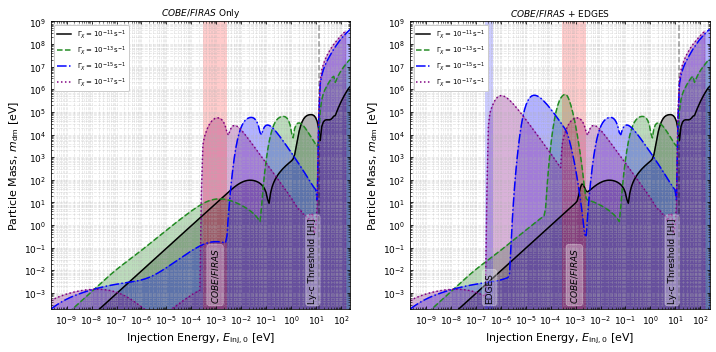

In [73]:
# photon_injection_case = 'bare'
# if photon_injection_case == 'bare':
#     f_dm_fisher = f_dm_fisher_bare
#     case = 'bare'
# if photon_injection_case == 'lyc':
#     f_dm_fisher = f_dm_fisher_lyc
#     case = 'lyc'
# if photon_injection_case == 'lyc_reio':
photon_injection_case = 'lyc_reio'
#     f_dm_fisher = f_dm_fisher_lyc_reio
#  
case = 'lyc+reio'

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>','o','s','d','v','>'])
colors = iter(['k','forestgreen','b','purple','green','magenta','r','b','orange','green','magenta'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
label_size = 9
title_size = 11
legend_size = 25
handle_length = 1.5

for ax in (ax1,ax2):
    ax.set_xscale('log')
    ax.set_yscale('log')


    ax.set_ylabel(label_mdm,size=title_size)
    ax.set_xlabel(label_injection_energy,size=title_size)
    ax.yaxis.set_label_coords(-.10,0.5)


    ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)

    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

    # manipulate x-axis ticks and labels
    ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True)

    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')

    
    if ax == ax2:
        ax.axvspan(1.e-3*xinj_to_Einj, 2e-3*xinj_to_Einj,ymin=0.,ymax=1, facecolor='blue', alpha=0.2)
    #ax.axvspan(0.5*xinj_to_Einj, 105*xinj_to_Einj,ymin=0.,ymax=0.1,  facecolor='orange', alpha=0.2,label=r'$\mathrm{PIXIE}$')
    ax.axvspan(1.2*xinj_to_Einj, 11.2*xinj_to_Einj,ymin=0.,ymax=1, facecolor='red', alpha=0.2)
    ax.axvline(5.7895e4*xinj_to_Einj,ls='--',alpha=0.4,c='k')
i = 0
#color=iter(cm.viridis(np.linspace(0.7,0,len(Gamma_values))))
for gamma in np.flip(Gamma_values):
    if i<=2 or i%2==0:
        i += 1
        continue
    col = next(colors)
    mk = next(mklist)
    #ax.plot(f_dm_high_z['curves'][i]['x'],f_dm_high_z['curves'][i]['mu'],c=col,label=r'$\Gamma_X=$'+scientific_notation(f_dm_high_z['Gamma_inj'][i])+r'$\,\mathrm{s^{-1}}$',ls='None', marker=mk,markersize=3)
    style = next(lstyles)
    f_dm_fisher = f_dm_fisher_lyc_reio_no_edges
    ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],(f_dm_fisher['curves'][i]['fdm']/(xinj_to_Einj*f_dm_fisher['curves'][i]['x']))**-1,c=col,
             label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=style, marker='None')
    ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-(f_dm_fisher['curves'][i]['fdm']/(xinj_to_Einj*f_dm_fisher['curves'][i]['x']))**-1,c=col,ls=style, marker='None')
    ax1.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], (np.abs(f_dm_fisher['curves'][i]['fdm']/(xinj_to_Einj*f_dm_fisher['curves'][i]['x'])))**-1,1e-100,color=col,alpha=0.3)

    f_dm_fisher = f_dm_fisher_lyc_reio_with_edges
    ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],(f_dm_fisher['curves'][i]['fdm']/(xinj_to_Einj*f_dm_fisher['curves'][i]['x']))**-1,c=col,label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=style, marker='None')
    ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-(f_dm_fisher['curves'][i]['fdm']/(xinj_to_Einj*f_dm_fisher['curves'][i]['x']))**-1,c=col,ls=style, marker='None')
    ax2.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], (np.abs(f_dm_fisher['curves'][i]['fdm']/(xinj_to_Einj*f_dm_fisher['curves'][i]['x'])))**-1,1e-100,color=col,alpha=0.3)


    i += 1

# ax2.text(0.05, 0.95, case , transform=ax2.transAxes, fontsize=9, verticalalignment='top',
#           bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

ax1.text(0.86, 0.02, 'Ly-c Threshold [HI]' , transform=ax1.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90,
        bbox=dict(facecolor='white', edgecolor='white', boxstyle='round',alpha=0.3))
ax1.text(0.53, 0.02, r'$COBE/FIRAS$' , transform=ax1.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90,
        bbox=dict(facecolor='white', edgecolor='white', boxstyle='round',alpha=0.3))
ax2.text(0.53, 0.02, r'$COBE/FIRAS$' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90,
        bbox=dict(facecolor='white', edgecolor='white', boxstyle='round',alpha=0.3))
ax2.text(0.25, 0.02, r'EDGES' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90,
        bbox=dict(facecolor='white', edgecolor='white', boxstyle='round',alpha=0.3))

ax2.text(0.86, 0.02, 'Ly-c Threshold [HI]' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90,
        bbox=dict(facecolor='white', edgecolor='white', boxstyle='round',alpha=0.3))

ax1.set_ylim(2.e-4,1e9)
ax1.set_xlim(xinj_to_Einj*1e-6,xinj_to_Einj*1e6)

ax2.set_ylim(2.e-4,1e9)
ax2.set_xlim(xinj_to_Einj*1e-6,xinj_to_Einj*1e6)
ax1.set_title(r'$COBE/FIRAS$ Only',fontsize=9)
ax2.set_title(r'$COBE/FIRAS$ + EDGES',fontsize=9)

#leg1 = plt.legend(loc=3,ncol=2,frameon=True,framealpha=0.6,fontsize = 9)
#legend_elements = [Line2D([0], [0], marker='o', color='k', label='best-fit to CT',ls='None',
#                          markerfacecolor='None', markersize=5)]
#leg2 = plt.legend(handles=legend_elements, loc=(0.745,0.6))
ax1.legend(loc=2,ncol=1,frameon=True,framealpha=1.,fontsize = 7)
ax2.legend(loc=2,ncol=1,frameon=True,framealpha=1.,fontsize = 7)


# ax.add_artist(leg2).tight_layout(pad=3.0)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig(path_to_figures + '/figures_for_paper_mdm_fisher_edges_'+photon_injection_case+'.pdf')
plt.show()
plt.close(fig)